### Question 1: Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best SVR predictor perform?

In [1]:
#let us import the california housing dataset to try Support Vector Machine regressor on it. Since the dataset does not require much preprocessing
#We will import dataset from the github repository of Aurelion the author of Hands on ML.
import os #for handling filesystem paths and directories
import tarfile #for working with .tar, .tar.gz, .tgz files
from six.moves import urllib #for retrieving files from URLs

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/' #Base URL for dataset repository
HOUSING_PATH = os.path.join("datasets","housing") #local folder path where you will save the dataset
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz" #Full URL to the compressed housing dataset online

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH): #To handle the entire download and extraction process
    if not os.path.isdir(housing_path): #to create a local folder to save the dataset if it does'nt exist already
        os.makedirs(housing_path) 
    tgz_path = os.path.join(housing_path, "housing.tgz") #defines a path where .tgz file will be saved
    urllib.request.urlretrieve(housing_url, tgz_path) #downloads the file from given url and saves it in tgz_path
    housing_tgz = tarfile.open(tgz_path) #opens the downloaded tar archive 
    housing_tgz.extractall(path = housing_path) #extracts all the contained files and download them at housing_path
    housing_tgz.close() #closing the archive after extraction

fetch_housing_data()

In [24]:
#loading the data using pandas
import pandas as pd
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [25]:
#let's take a look at the info
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We will move straight to our goal of solving the question without much analysis of the dataset. If anyone wants to see the analysis of this dataset they can check out my other jupyter notebook in the same repository.

<Axes: >

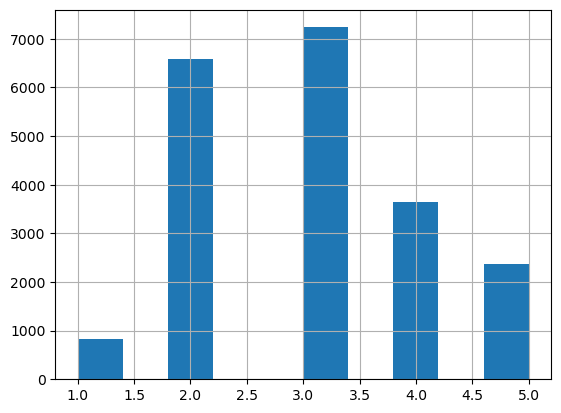

In [26]:
#our goal is to convert this continuous column into discrete so that we can use its frequency to take a stratified sample for our training set
import numpy as np
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])
housing['income_cat'].hist()

In [30]:
from sklearn.model_selection import StratifiedShuffleSplit
strat_sampling = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in strat_sampling.split(housing, housing.income_cat):
    train_set = housing.loc[train_index]
    test_set = housing.loc[test_index]
train_set.drop('income_cat', axis=1, inplace=True)
test_set.drop('income_cat', axis =1, inplace = True)

In [32]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


In [36]:
#Now we have to impute the missing value in the total bedrooms column, scale all the numerical features and perform one hot encoding on the categorical variable
#We will use a pipeline for these transformations
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_columns = train_set.drop(['ocean_proximity','median_house_value'], axis=1).columns.values
cat_columns = ['ocean_proximity']

num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('one_hot' , OneHotEncoder())
])

c_transformer1 = ColumnTransformer([
    ('num', num_pipeline, num_columns),
    ('col', cat_pipeline, cat_columns)
])
y_train = train_set['median_house_value']
X= train_set.drop('median_house_value', axis=1)
X_train = c_transformer1.fit_transform(X)
X_train[:5]

array([[-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.64037127,
         0.73260236,  0.55628602, -0.8936472 ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763,  1.26146668,  0.78156132,
         0.53361152,  0.72131799,  1.292168  ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, -0.46977281, -0.54513828,
        -0.67467519, -0.52440722, -0.52543365,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ],
       [ 1.22173797, -1.35147437, -0.37006852, -0.34865152, -0.03636724,
        -0.46761716, -0.03729672, -0.86592882,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ],
       [ 0.43743108, -0.63581817, -0.13148926,  0.42717947,  0.27279028,
         0.37406031,  0.22089846,  0.32575178,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

In [40]:
#Now we have no missing values and the data has also been converted to numerical values. Let us solve our question now
from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV
params = [
    {'kernel':['linear'], 'C':[20,40,60]},
    {'kernel':['rbf'], 'C':[20,40,60], 'gamma':[6,8]}
]
support_regressor = SVR()
grid_model = GridSearchCV(support_regressor, param_grid=params, cv=3, scoring='neg_mean_squared_error', return_train_score=True, verbose =2)
grid_model.fit(X_train, y_train)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ................................C=20, kernel=linear; total time=   5.0s
[CV] END ................................C=20, kernel=linear; total time=   4.6s
[CV] END ................................C=20, kernel=linear; total time=   4.4s
[CV] END ................................C=40, kernel=linear; total time=   4.4s
[CV] END ................................C=40, kernel=linear; total time=   4.5s
[CV] END ................................C=40, kernel=linear; total time=   4.9s
[CV] END ................................C=60, kernel=linear; total time=   4.5s
[CV] END ................................C=60, kernel=linear; total time=   4.5s
[CV] END ................................C=60, kernel=linear; total time=   4.6s
[CV] END ..........................C=20, gamma=6, kernel=rbf; total time=   9.8s
[CV] END ..........................C=20, gamma=6, kernel=rbf; total time=  10.0s
[CV] END ..........................C=20, gamma=6,

GridSearchCV(cv=3, estimator=SVR(),
             param_grid=[{'C': [20, 40, 60], 'kernel': ['linear']},
                         {'C': [20, 40, 60], 'gamma': [6, 8],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

The above model will be fitted (3+6)*3 = 27 times.

In [41]:
results = grid_model.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(np.sqrt(-mean_score), params)

79659.76090065695 {'C': 20, 'kernel': 'linear'}
75298.9858229898 {'C': 40, 'kernel': 'linear'}
73699.8774180053 {'C': 60, 'kernel': 'linear'}
118871.35929038526 {'C': 20, 'gamma': 6, 'kernel': 'rbf'}
118895.97083823607 {'C': 20, 'gamma': 8, 'kernel': 'rbf'}
118805.28457731042 {'C': 40, 'gamma': 6, 'kernel': 'rbf'}
118855.9480826383 {'C': 40, 'gamma': 8, 'kernel': 'rbf'}
118747.57942773397 {'C': 60, 'gamma': 6, 'kernel': 'rbf'}
118817.15500841939 {'C': 60, 'gamma': 8, 'kernel': 'rbf'}


In [52]:
svr_grid_model = grid_model.best_estimator_
y_test = test_set['median_house_value']
X_t = test_set.drop('median_house_value',axis =1)
X_test = c_transformer1.fit_transform(X_t)
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(y_test, svr_grid_model.predict(X_test))))

70898.24275952141


The best model we got by using GridSearchCV is performing very well even on the test set, in the next question we will try finding the best parameters using RandomizedSearchCV.

### Question 2: Try replacing `GridSearchCV` with `RandomizedSearchCV`.

In [50]:
from sklearn.model_selection import RandomizedSearchCV
paramgrid = [
    {'kernel':['linear', 'rbf'], 'C':[i for i in range(20,25)], 'gamma':[i for i in range(200,205)]}
]

svr= SVR()
rndm_model = RandomizedSearchCV(svr, param_distributions= paramgrid, cv=3, scoring='neg_mean_squared_error', n_iter =10, verbose =2)
rndm_model.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ........................C=24, gamma=202, kernel=rbf; total time=  10.1s
[CV] END ........................C=24, gamma=202, kernel=rbf; total time=   9.5s
[CV] END ........................C=24, gamma=202, kernel=rbf; total time=   9.5s
[CV] END .....................C=22, gamma=200, kernel=linear; total time=   4.4s
[CV] END .....................C=22, gamma=200, kernel=linear; total time=   4.3s
[CV] END .....................C=22, gamma=200, kernel=linear; total time=   4.5s
[CV] END .....................C=21, gamma=203, kernel=linear; total time=   4.4s
[CV] END .....................C=21, gamma=203, kernel=linear; total time=   4.5s
[CV] END .....................C=21, gamma=203, kernel=linear; total time=   4.5s
[CV] END .....................C=23, gamma=200, kernel=linear; total time=   4.4s
[CV] END .....................C=23, gamma=200, kernel=linear; total time=   4.5s
[CV] END .....................C=23, gamma=200, k

RandomizedSearchCV(cv=3, estimator=SVR(),
                   param_distributions=[{'C': [20, 21, 22, 23, 24],
                                         'gamma': [200, 201, 202, 203, 204],
                                         'kernel': ['linear', 'rbf']}],
                   scoring='neg_mean_squared_error', verbose=2)

In [51]:
results = rndm_model.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(np.sqrt(-mean_score), params)

118930.85366093068 {'kernel': 'rbf', 'gamma': 202, 'C': 24}
78970.42741499677 {'kernel': 'linear', 'gamma': 200, 'C': 22}
79313.64659256501 {'kernel': 'linear', 'gamma': 203, 'C': 21}
78590.44555422779 {'kernel': 'linear', 'gamma': 200, 'C': 23}
79659.76090065695 {'kernel': 'linear', 'gamma': 200, 'C': 20}
78234.31625992691 {'kernel': 'linear', 'gamma': 201, 'C': 24}
118930.85110977007 {'kernel': 'rbf', 'gamma': 203, 'C': 21}
79659.76090065695 {'kernel': 'linear', 'gamma': 201, 'C': 20}
78234.31625992691 {'kernel': 'linear', 'gamma': 200, 'C': 24}
118930.84784983096 {'kernel': 'rbf', 'gamma': 200, 'C': 20}


In [53]:
svr_rndm_model = rndm_model.best_estimator_
print(np.sqrt(mean_squared_error(y_test, svr_rndm_model.predict(X_test))))

74099.59740895333


RandomizedSearchCV took less time to find the best parameters and it is also performing pretty well on the test set. For further questions we will proceed with the best model given to us by RandomizedSearchCV. There is no particular reason for it, but just for fun.

### Question 3: Try adding a transformer in the preparation pipeline to select only the most important attributes.

Let us formulate the question in a simpler way: Since we have already trained a model, we will use some method to get feature importance scores, we will then use those scores to shortlist only the important features by adding a custom transformer in the data preparation pipeline.

In [65]:
#let's find out the important attributes using the permutaion_importance feature available in sklearn.
from sklearn.inspection import permutation_importance
importance_scores = permutation_importance(svr_rndm_model, X_test, y_test, scoring = 'r2') 
clmn1 =list(X.columns.values[:-1])
clmn2=list(c_transformer1.named_transformers_['col'].named_steps['one_hot'].categories_[0])
clmns = clmn1+clmn2
clmns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [70]:
pd.DataFrame({"importance_means":importance_scores.importances_mean,"column_name": clmns}).sort_values('importance_means', ascending=False)

,importance_means,column_name
7,0.687099,median_income
9,0.068440,INLAND
0,0.051503,longitude
1,0.046495,latitude
5,0.045352,population
2,0.018435,housing_median_age
6,0.014648,households
4,0.013910,total_bedrooms
8,0.010231,<1H OCEAN
12,0.007304,NEAR OCEAN


In [85]:
#now we have a list of importance scores and a list of all the column named that were present in our training dataset
#let us create a custom transformer in which we will input there scores and an integer k denoting how many features we want to select.

from sklearn.base import BaseEstimator, TransformerMixin
class KImportantFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, importance_scores, K):
        self.importance_scores = importance_scores
        self.K= K
    @staticmethod
    def get_indices(scores, k):
        return np.argsort(scores)[-k:]
        
    def fit(self, X, y=None):
        self.feature_indices_ = self.get_indices(self.importance_scores, self.K)
        return self
    def transform(self, X):
        return X[:,self.feature_indices_]
        

In [91]:
#let's try out this custom transformer
important4= KImportantFeatures(importance_scores.importances_mean, 4)
X_important = important4.fit_transform(X_train)
X_important

array([[ 1.34743822, -0.94135046,  1.        , -0.8936472 ],
       [-1.19243966,  1.17178212,  0.        ,  1.292168  ],
       [-0.1259716 ,  0.26758118,  1.        , -0.52543365],
       ...,
       [ 1.31001828, -1.5707942 ,  0.        , -0.36547546],
       [ 1.2492109 , -1.56080303,  0.        ,  0.16826095],
       [ 2.02567448, -1.28105026,  1.        , -0.390569  ]])

In [94]:
#the class is working fine let's add it to the pipeline
final_pipeline = Pipeline([
    ('full_pipeline', c_transformer1),
    ('feature_selection',KImportantFeatures(importance_scores.importances_mean,5) )
])
X_final = final_pipeline.fit_transform(X)
X_final[:5]

array([[ 0.73260236,  1.34743822, -0.94135046,  1.        , -0.8936472 ],
       [ 0.53361152, -1.19243966,  1.17178212,  0.        ,  1.292168  ],
       [-0.67467519, -0.1259716 ,  0.26758118,  1.        , -0.52543365],
       [-0.46761716, -1.35147437,  1.22173797,  0.        , -0.86592882],
       [ 0.37406031, -0.63581817,  0.43743108,  0.        ,  0.32575178]])

We have successfully created our pipeline and implemented it for feature selection.

### Question 4: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [102]:
prediction_pipeline = Pipeline([
    ('full_pipeline', c_transformer1),
    ('feature_selection', KImportantFeatures(importance_scores.importances_mean,5)),
    ('prediction',SVR(**rndm_model.best_params_))
])
prediction_pipeline.fit(X,y_train)

Pipeline(steps=[('full_pipeline',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)),
                                                 ('col',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['ocean_proximity'])])),
                ('feature_selection',
                 KImportantFeatures(K=5,
                                    importance_scores=array([5.15031491e-02, 4.64953753e-02, 1.84353388e-02, 3.51135968e-03,
       1.39103301e-02, 4.53517613e-02, 1.46484281e-02, 6.87098556e-01,
       1.02306354e-02, 6.84403012e-02, 1.21781760e-06, 3.35675664e-03,
       7.30368499e-03]))),
                ('prediction', SVR(C=24, gamma=201, kernel='linear'))])

In [107]:
print(np.sqrt(mean_squared_error(y_train,prediction_pipeline.predict(X) )))

79060.0372833078


We are getting a similar sort of score as we were getting below even after using only 5 important features. Therefore we can use this pipeline as our final pipeline for prediction of any new data.